# Part 1: Environment Setup and Imports

The instructions below are for installing the python packages required for running this code

In [ ]:
# Cell 1: Install required packages
!pip install sionna tensorflow torch transformers numpy matplotlib seaborn scikit-learn

# Part 2: Communication System Simulation with Sionna

In [ ]:
# Cell 2: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Sionna and TensorFlow
import tensorflow as tf
import sionna as sn
from sionna.phy.channel import RayleighBlockFading, AWGN
#from sionna.phy.channel.tr38901 import AntennaArray, CDL
#from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Constellation, Mapper, Demapper, BinarySource
from sionna.phy.utils import ebnodb2no

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

print("All packages imported successfully!")

All packages imported successfully!


In [4]:
# Cell 3: Define communication system parameters
class CommSystemConfig:
    def __init__(self):
        # Modulation parameters
        self.constellation_type = "qam"
        self.num_bits_per_symbol = 4  # 16-QAM
        
        # Channel parameters
        self.carrier_frequency = 3.5e9  # 3.5 GHz
        self.delay_spread = 100e-9      # 100 ns
        self.speed = 10.0               # 10 m/s
        
        # Transmission parameters
        self.num_tx_ant = 2
        self.num_rx_ant = 2
        self.fft_size = 64
        self.num_ofdm_symbols = 14
        self.pilot_ratio = 0.25
        
        # SNR range for different channel conditions
        self.snr_range_db = np.linspace(-10, 20, 7)  # Different channel conditions
        
        # Data generation
        self.samples_per_condition = 1000
        self.sequence_length = 128  # Time series length

config = CommSystemConfig()
print(f"Configuration: {config.__dict__}")

Configuration: {'constellation_type': 'qam', 'num_bits_per_symbol': 4, 'carrier_frequency': 3500000000.0, 'delay_spread': 1e-07, 'speed': 10.0, 'num_tx_ant': 2, 'num_rx_ant': 2, 'fft_size': 64, 'num_ofdm_symbols': 14, 'pilot_ratio': 0.25, 'snr_range_db': array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.]), 'samples_per_condition': 1000, 'sequence_length': 128}


Sionna offers several useful modules for simulating communication systems. 
The `Constellation` class defines a constellation, i.e., a complex-valued vector of constellation points.
The `Mapper` and `Demapper` classes create objects that can be used to map binary tensors to points of the constellation and viceversa.

The `BinarySource` class provides a random bit generator, while the `AWGN` class provides a noise generator.

In [ ]:
# Cell 4: Build the communication system components
class SionnaCommSystem:
    def __init__(self, config):
        self.config = config
        
        # Create constellation
        self.constellation = Constellation(
            constellation_type=config.constellation_type,
            num_bits_per_symbol=config.num_bits_per_symbol
        )
        
        # Create mapper and demapper
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(
            demapping_method="maxlog",
            constellation=self.constellation
        )
        
        # Create binary source
        self.binary_source = BinarySource()
        
        # Create channel models
        self.awgn_channel = AWGN()
        
    def generate_data_batch(self, batch_size, ebno_db, channel_type="awgn"):
        """Generate a batch of communication data"""
        
        # Generate random bits
        num_bits = self.config.sequence_length * self.config.num_bits_per_symbol
        bits = self.binary_source([batch_size, num_bits])
        
        # Map bits to symbols
        symbols = self.mapper(bits)
        
        # Add channel effects
        no = ebnodb2no(ebno_db, self.config.num_bits_per_symbol, 1.0)
        received_symbols = self.awgn_channel(symbols, no)
        
        return {
            'transmitted_bits': bits.numpy(),
            'transmitted_symbols': symbols.numpy(),
            'received_symbols': received_symbols.numpy(),
            'channel_type': channel_type,
            'snr_db': ebno_db
        }

comm_system = SionnaCommSystem(config)
print("Communication system initialized successfully!")

Communication system initialized successfully!


We can now generate the dataset by creating datapoints according to 3 different levels of SNR. We save the datapoints as numpy arrays.

In [26]:
# Cell 5: Generate comprehensive dataset
def generate_communication_dataset(comm_system, config):
    """Generate dataset with multiple channel conditions and types"""
    
    all_data = []
    labels = []
    metadata = []
    
    # Define channel conditions (classes for classification)
    channel_conditions = [
        ("awgn", -5),    # Class 0: AWGN Low SNR
        ("awgn", 5),     # Class 1: AWGN Medium SNR  
        ("awgn", 15),    # Class 2: AWGN High SNR
    ]
    
    print("Generating communication dataset...")
    
    for class_idx, (channel_type, snr_db) in enumerate(channel_conditions):
        print(f"Generating data for {channel_type} channel, SNR={snr_db}dB (Class {class_idx})")
        
        for batch_idx in range(config.samples_per_condition // 32):  # 32 samples per batch
            batch_data = comm_system.generate_data_batch(
                batch_size=32,
                ebno_db=snr_db,
                channel_type=channel_type
            )
            
            # Extract features from received symbols (I/Q components)
            received_symbols = batch_data['received_symbols']
            
            # Create feature vectors: [real, imag, magnitude, phase]
            features = np.stack([
                np.real(received_symbols),
                np.imag(received_symbols),
                np.abs(received_symbols),
                np.angle(received_symbols)
            ], axis=-1)  # Shape: (batch_size, sequence_length, 4)
            
            # Store data
            for i in range(features.shape[0]):
                all_data.append(features[i])
                labels.append(class_idx)
                metadata.append({
                    'channel_type': channel_type,
                    'snr_db': snr_db,
                    'class': class_idx
                })
    
    # Convert to numpy arrays
    X = np.array(all_data)  # Shape: (num_samples, sequence_length, num_features)
    y = np.array(labels)
    
    print(f"Dataset generated: {X.shape} samples, {len(np.unique(y))} classes")
    return X, y, metadata, channel_conditions

# Generate the dataset
X, y, metadata, channel_conditions = generate_communication_dataset(comm_system, config)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Channel conditions: {channel_conditions}")

Generating communication dataset...
Generating data for awgn channel, SNR=-5dB (Class 0)


Generating data for awgn channel, SNR=5dB (Class 1)
Generating data for awgn channel, SNR=15dB (Class 2)
Dataset generated: (2976, 128, 4) samples, 3 classes
Dataset shape: (2976, 128, 4)
Labels shape: (2976,)
Number of classes: 3
Channel conditions: [('awgn', -5), ('awgn', 5), ('awgn', 15)]


We can now do a quick visualization of our data using the `Matplotlib` library.

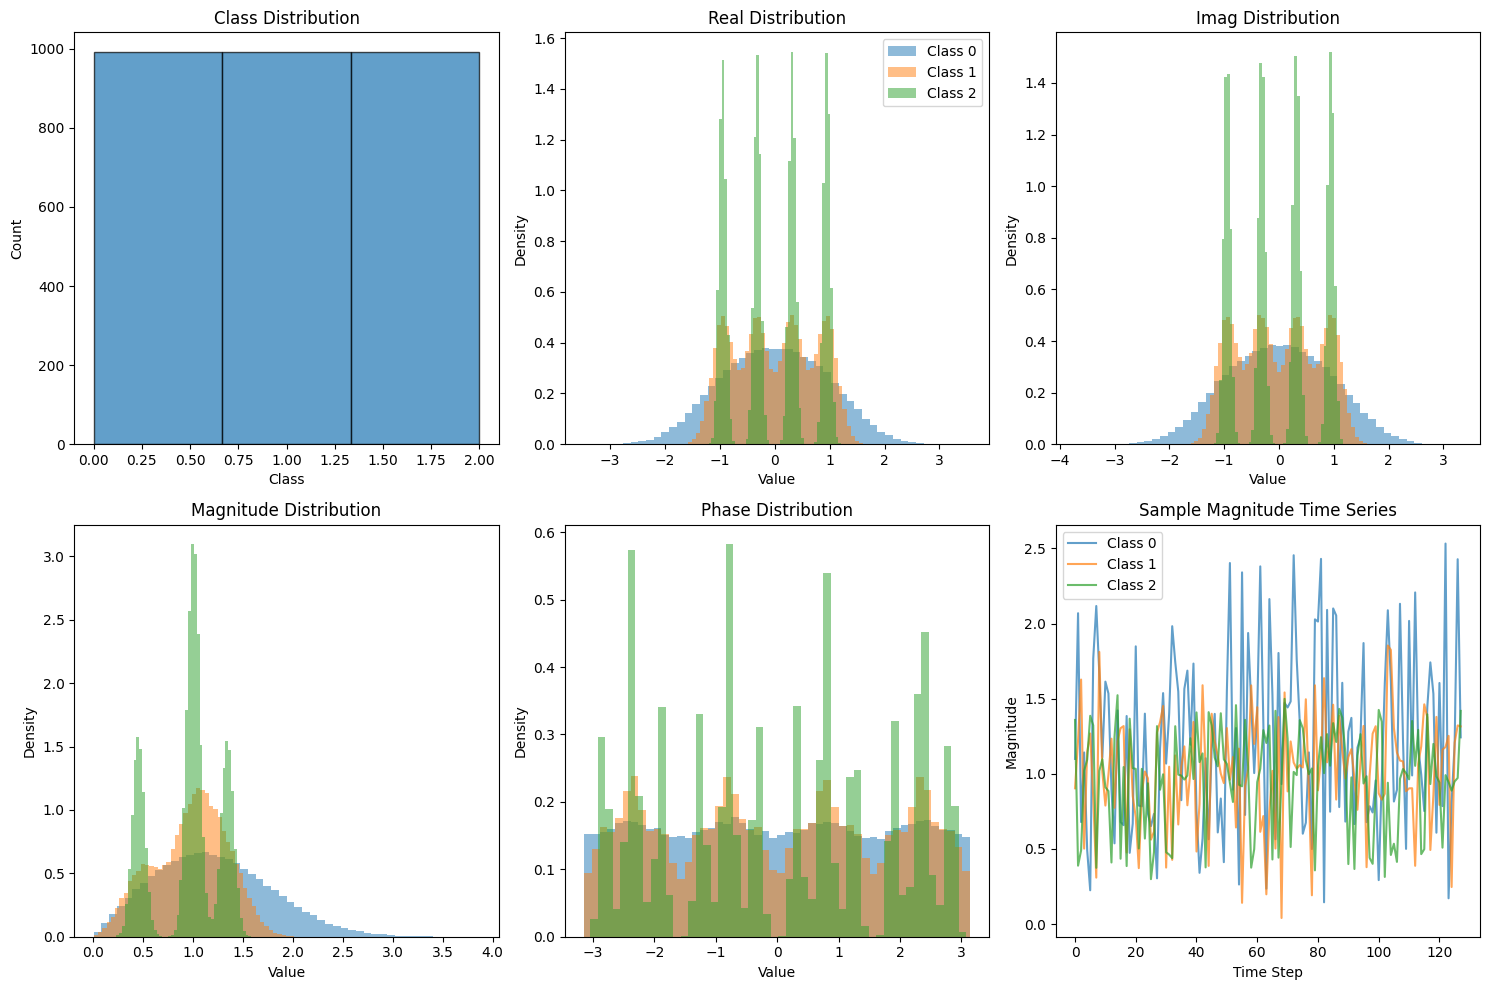

In [27]:
# Cell 6: Data exploration and visualization
def plot_dataset_analysis(X, y, channel_conditions):
    """Visualize the generated dataset"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: Class distribution
    axes[0, 0].hist(y, bins=len(np.unique(y)), alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Class Distribution')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Count')
    
    # Plot 2: Feature distributions for different classes
    feature_names = ['Real', 'Imag', 'Magnitude', 'Phase']
    for i in range(4):
        if i < 2:
            ax = axes[0, i+1]
        else:
            ax = axes[1, i-2]
            
        for class_idx in range(len(channel_conditions)):
            class_data = X[y == class_idx]
            ax.hist(class_data[:, :, i].flatten(), bins=50, alpha=0.5, 
                   label=f'Class {class_idx}', density=True)
        
        ax.set_title(f'{feature_names[i]} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        if i == 0:
            ax.legend()
    
    # Plot 6: Sample time series for each class
    axes[1, 2].clear()
    for class_idx in range(min(3, len(channel_conditions))):  # Show first 3 classes
        class_data = X[y == class_idx]
        sample_idx = 0
        axes[1, 2].plot(class_data[sample_idx, :, 2], label=f'Class {class_idx}', alpha=0.7)
    
    axes[1, 2].set_title('Sample Magnitude Time Series')
    axes[1, 2].set_xlabel('Time Step')
    axes[1, 2].set_ylabel('Magnitude')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

plot_dataset_analysis(X, y, channel_conditions)

# Part 3: Transformer Model Implementation with PyTorch

To create a model in PyTorch, we need to subclass the `nn.Module` class. 
In the `__init__` method we specify all the submodules (i.e., components of our neural network), while in the `forward` method we define how they are used to compute the output given the input. PyTorch will then automatically take care of computing gradients during training.

In [28]:
# Cell 7: Define Transformer model for time series classification
class CommunicationTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes, 
                 sequence_length, dropout=0.1):
        super(CommunicationTransformer, self).__init__()
        
        self.d_model = d_model
        self.sequence_length = sequence_length
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = self._create_positional_encoding(sequence_length, d_model)
        
        # Transformer encoder
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
    def _create_positional_encoding(self, sequence_length, d_model):
        """Create positional encoding"""
        pe = torch.zeros(sequence_length, d_model)
        position = torch.arange(0, sequence_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # Shape: (1, sequence_length, d_model)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        batch_size = x.size(0)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch_size, sequence_length, d_model)
        
        # Add positional encoding
        x = x + self.positional_encoding.to(x.device)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # (batch_size, sequence_length, d_model)
        
        # Global average pooling
        x = x.transpose(1, 2)  # (batch_size, d_model, sequence_length)
        x = self.global_pool(x).squeeze(-1)  # (batch_size, d_model)
        
        # Classification
        output = self.classifier(x)  # (batch_size, num_classes)
        
        return output

# Model parameters
model_config = {
    'input_dim': 4,  # [real, imag, magnitude, phase]
    'd_model': 128,
    'nhead': 8,
    'num_layers': 4,
    'num_classes': len(channel_conditions),
    'sequence_length': config.sequence_length,
    'dropout': 0.1
}

print(f"Model configuration: {model_config}")

Model configuration: {'input_dim': 4, 'd_model': 128, 'nhead': 8, 'num_layers': 4, 'num_classes': 3, 'sequence_length': 128, 'dropout': 0.1}


We now preprocess the data for training.
PyTorch uses the `DataLoader` class to handle the loading and batching of the data. 
We first normalize and split the data into training, validation, and testing subsets, and then transform it into PyTorch tensors (this allows us to use GPUs).

In [29]:
# Cell 8: Prepare data for PyTorch training
def prepare_pytorch_data(X, y, test_size=0.2, val_size=0.2):
    """Prepare data for PyTorch training"""
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42, stratify=y_temp
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, test_loader, scaler

# Prepare data
train_loader, val_loader, test_loader, scaler = prepare_pytorch_data(X, y)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 56
Validation batches: 19
Test batches: 19


Finally, we can train our model. 
We define the loss (`criterion`), the optimizer (`Adam`) and iterate through the data. At every iteration we pass the data to the model, compute the output, compute the gradients, and then call the optimizer to update the parameters based on the gradients. 
At the end of every epoch (iteration through the whole training set), we evaluate the model on the validation data. We then save the model parameters with the best performance on the validation set.

In [ ]:
# Cell 9: Training function
def train_transformer_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train the transformer model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # zero out the gradients associated to the parameters (otherwise they will be accumulated across examples)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward() # compute gradients
            optimizer.step() # optimize parameters using the gradients
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

# Initialize and train the model
model = CommunicationTransformer(**model_config)
training_history = train_transformer_model(model, train_loader, val_loader, num_epochs=30)

print("Training completed!")

Training on device: cuda
Model parameters: 802,179
Epoch [10/30]
Train Loss: 0.1384, Train Acc: 96.86%
Val Loss: 0.2949, Val Acc: 91.26%
--------------------------------------------------
Epoch [20/30]
Train Loss: 0.0241, Train Acc: 99.38%
Val Loss: 0.0325, Val Acc: 99.16%
--------------------------------------------------
Epoch [30/30]
Train Loss: 0.0045, Train Acc: 99.83%
Val Loss: 0.0253, Val Acc: 99.50%
--------------------------------------------------
Training completed!


Let's look at how the loss and accuracy of our model has changed during training.

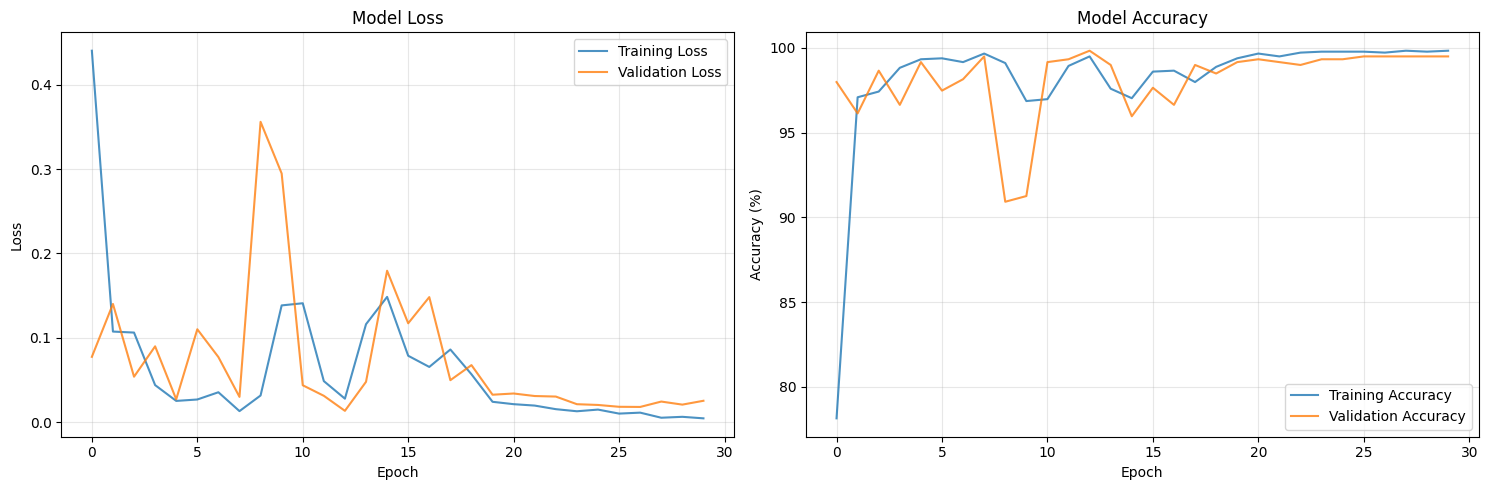

Best validation loss: 0.0134
Final validation accuracy: 99.50%


In [31]:
# Cell 10: Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', alpha=0.8)
    ax1.plot(history['val_losses'], label='Validation Loss', alpha=0.8)
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', alpha=0.8)
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', alpha=0.8)
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best validation loss: {history['best_val_loss']:.4f}")
    print(f"Final validation accuracy: {history['val_accuracies'][-1]:.2f}%")

plot_training_history(training_history)

# Part 4: Model Evaluation and Analysis

Lastly, we evaluate our model on the unseen test data.

In [32]:
# Cell 11: Comprehensive model evaluation
def evaluate_model(model, test_loader, channel_conditions):
    """Comprehensive model evaluation"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
    
    # Create class names
    class_names = [f"{ch_type}_{snr}dB" for ch_type, snr in channel_conditions]
    
    # Classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'classification_report': report,
        'confusion_matrix': cm,
        'class_names': class_names
    }

# Evaluate the model
evaluation_results = evaluate_model(model, test_loader, channel_conditions)

print(f"Test Accuracy: {evaluation_results['accuracy']:.2f}%")
print("\nClassification Report:")
print(evaluation_results['classification_report'])

Test Accuracy: 99.16%

Classification Report:
              precision    recall  f1-score   support

   awgn_-5dB       1.00      1.00      1.00       198
    awgn_5dB       1.00      0.97      0.99       199
   awgn_15dB       0.98      1.00      0.99       199

    accuracy                           0.99       596
   macro avg       0.99      0.99      0.99       596
weighted avg       0.99      0.99      0.99       596



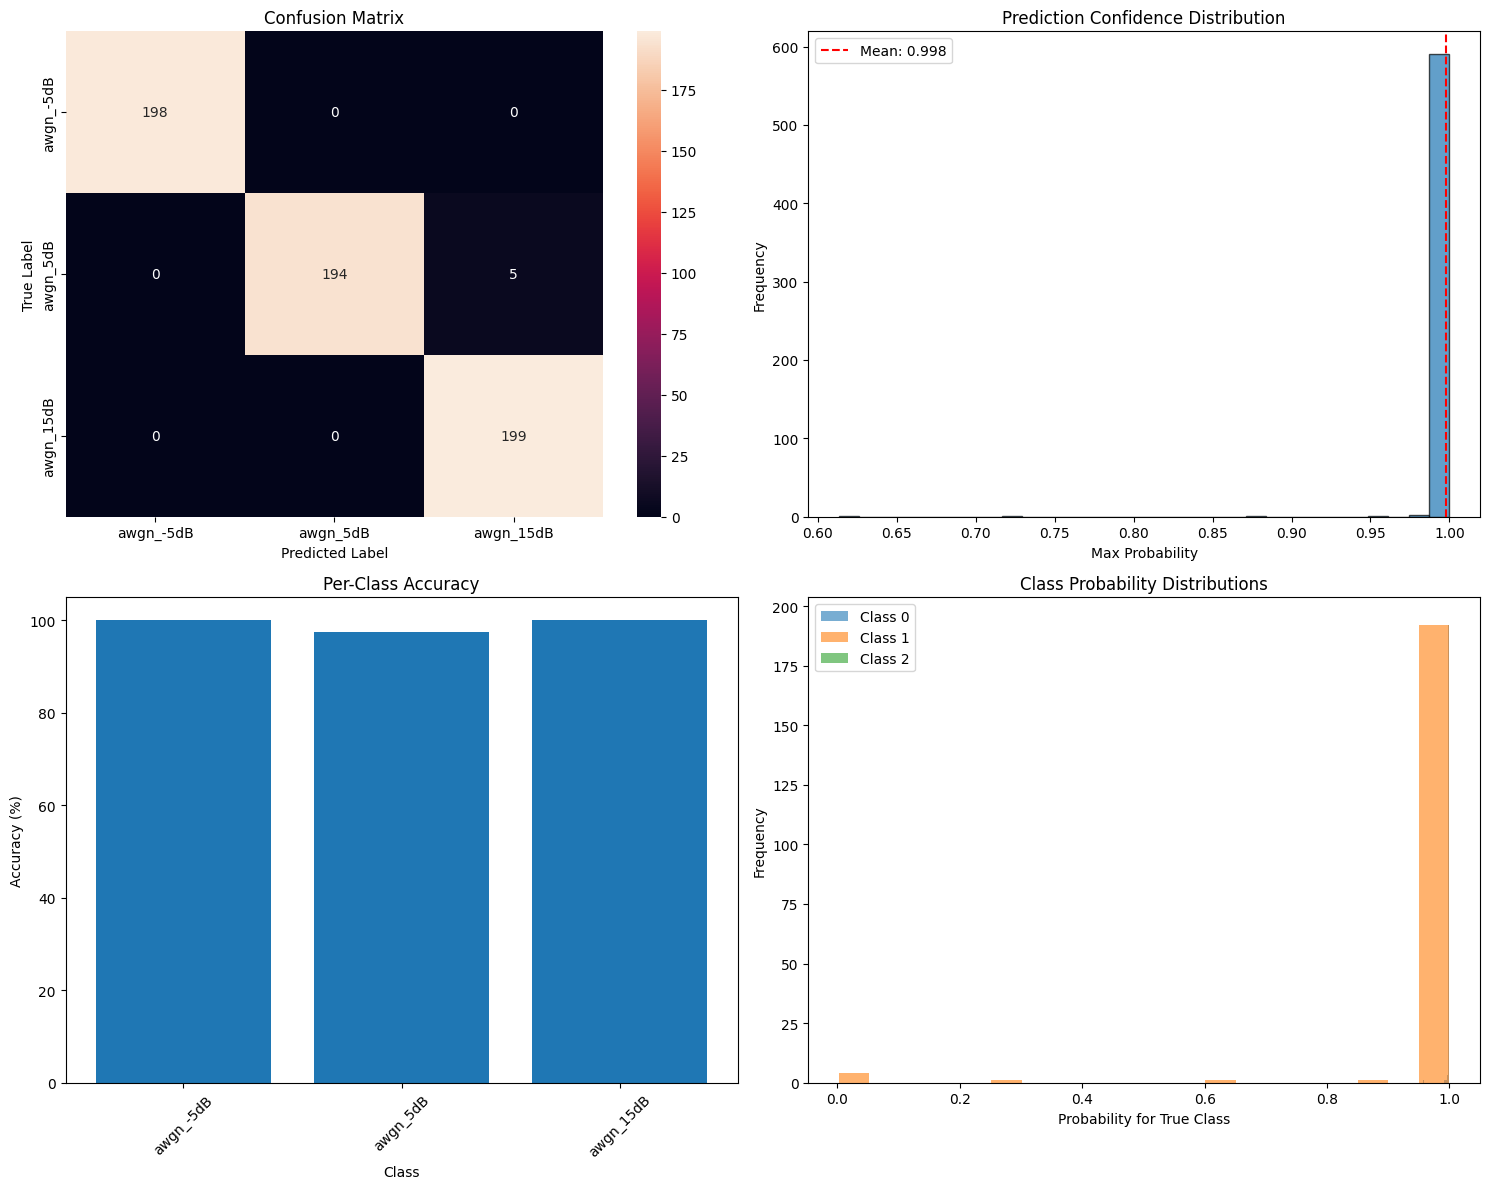

In [33]:
# Cell 12: Visualization of results
def plot_evaluation_results(eval_results):
    """Plot evaluation results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    sns.heatmap(eval_results['confusion_matrix'], 
                annot=True, fmt='d', 
                xticklabels=eval_results['class_names'],
                yticklabels=eval_results['class_names'],
                ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # Prediction confidence distribution
    probabilities = np.array(eval_results['probabilities'])
    max_probs = np.max(probabilities, axis=1)
    
    axes[0, 1].hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Prediction Confidence Distribution')
    axes[0, 1].set_xlabel('Max Probability')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(max_probs), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(max_probs):.3f}')
    axes[0, 1].legend()
    
    # Per-class accuracy
    cm = eval_results['confusion_matrix']
    per_class_acc = np.diag(cm) / np.sum(cm, axis=1) * 100
    
    axes[1, 0].bar(range(len(per_class_acc)), per_class_acc)
    axes[1, 0].set_title('Per-Class Accuracy')
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_xticks(range(len(eval_results['class_names'])))
    axes[1, 0].set_xticklabels(eval_results['class_names'], rotation=45)
    
    # Probability distribution for each class
    for class_idx in range(len(eval_results['class_names'])):
        class_probs = probabilities[np.array(eval_results['labels']) == class_idx, class_idx]
        axes[1, 1].hist(class_probs, alpha=0.6, label=f'Class {class_idx}', bins=20)
    
    axes[1, 1].set_title('Class Probability Distributions')
    axes[1, 1].set_xlabel('Probability for True Class')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_evaluation_results(evaluation_results)

We can also visualize the attention scores inside each Transformer layer. This can give us a hint as to what the model is computing, though they are not always easy to understand. In general, you should never rely 100% on interpretations of the attention scores to understand what the model is doing.

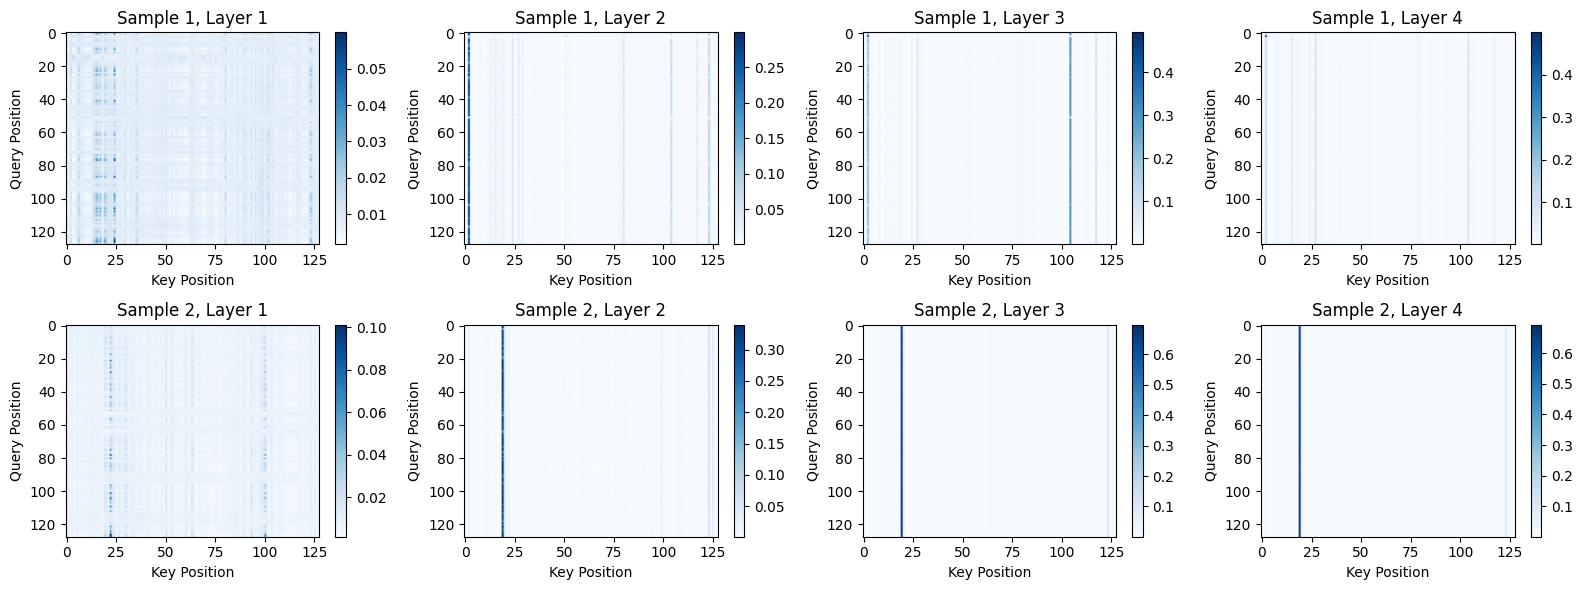

In [ ]:
def visualize_attention_patterns(model, test_loader, num_samples=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Get a batch
    data_iter = iter(test_loader)
    batch_x, batch_y = next(data_iter)
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    
    attention_weights = []

    # Save original forward methods
    original_forwards = []
    for layer in model.transformer_encoder.layers:
        original_forwards.append(layer.self_attn.forward)

    # Monkey-patch to force need_weights=True
    for layer in model.transformer_encoder.layers:
        def forward_with_weights(query, key, value, **kwargs):
            kwargs['need_weights'] = True
            return layer.self_attn.__class__.forward(layer.self_attn, query, key, value, **kwargs)
        layer.self_attn.forward = forward_with_weights

    # Hook to capture attention weights
    def attention_hook(module, input, output):
        attn_w = output[1]  # shape: (batch, seq_len, seq_len) - it's already averaged over heads
        if attn_w is not None:
            attention_weights.append(attn_w.detach().cpu())

    hooks = []
    for layer in model.transformer_encoder.layers:
        hooks.append(layer.self_attn.register_forward_hook(attention_hook))
    
    # Forward pass
    with torch.no_grad():
        _ = model(batch_x[:num_samples])
    
    # Remove hooks and restore original forwards
    for h in hooks:
        h.remove()
    for layer, orig_fwd in zip(model.transformer_encoder.layers, original_forwards):
        layer.self_attn.forward = orig_fwd
    
    # Plot
    num_layers = len(attention_weights)
    fig, axes = plt.subplots(num_samples, num_layers, figsize=(4*num_layers, 3*num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_layers == 1:
        axes = np.expand_dims(axes, 1)
    
    for sample_idx in range(num_samples):
        for layer_idx, attn_w in enumerate(attention_weights):
            attn = attn_w[sample_idx].numpy()
            ax = axes[sample_idx, layer_idx]
            im = ax.imshow(attn, cmap='Blues', aspect='auto')
            ax.set_title(f"Sample {sample_idx+1}, Layer {layer_idx+1}")
            ax.set_xlabel("Key Position")
            ax.set_ylabel("Query Position")
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

visualize_attention_patterns(model, test_loader, num_samples=2)